# Hands-On Lab: Atomic Descriptors for Machine Learning Potentials

## What is this lab about?

Machine learning potentials (MLIPs) are models that learn to predict the energy of an atomic structure from its geometry — without solving quantum mechanics every time. The key ingredient is a **descriptor**: a mathematical recipe that converts an arrangement of atoms into a fixed-size list of numbers that a machine learning model can use.

The challenge is that these descriptors must respect the laws of physics:
- Moving all atoms together should not change the energy (**translation invariance**)
- Rotating the whole system should not change the energy (**rotation invariance**)
- Swapping atom labels should not change the energy (**permutation invariance**)

In this lab you will:
1. **Run** working demo cells and observe results
2. **Experiment** by changing a few highlighted parameters
3. **Reflect** on what your observations mean physically

No advanced coding needed — every experiment cell only asks you to change one or two labelled values.

---

## Why Do We Need Descriptors?

**The Central Challenge:**
Machine learning models expect fixed-size input vectors, but atomic systems have:
- **Variable number of atoms** (can't directly feed to ML)
- **Arbitrary ordering** (atom indices are meaningless)
- **Orientation in space** (physics is rotation-invariant)
- **Absolute position** (only relative positions matter)

**The Solution:**
**Descriptors** are mathematical transformations that convert atomic configurations into fixed-size feature vectors while respecting physical symmetries.

$$\text{Atomic Structure} \xrightarrow{\text{Descriptor}} \text{Fixed-size vector} \xrightarrow{\text{ML Model}} \text{Energy/Forces}$$

## Setup — Run this first

This installs and imports everything needed. You don't need to change anything.

In [ ]:
#!pip install scipy numpy matplotlib ase dscribe -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import sph_harm_y
from ase import Atoms
from ase.build import molecule
from dscribe.descriptors import SOAP
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 11, 'figure.figsize': (9, 5)})
np.random.seed(42)
print('✓ All libraries loaded successfully!')


✓ All libraries loaded successfully!


---
# Part 1: The Three Physical Symmetries 

## Why do symmetries matter?

Imagine you measure the energy of a water molecule. Now you translate the entire molecule 10 Å to the right. The energy must be **exactly the same** — there is no preferred location in empty space. Same for rotations and for swapping atom labels.

A descriptor that violates any of these symmetries would force the ML model to relearn the same physical fact from many redundant training examples — very wasteful.

The simplest descriptor that satisfies all three symmetries is a **distance histogram**: count how many atom pairs fall within each distance bin.




## Symmetries

### 1️ Translation Invariance
$$\mathbf{D}(\{\mathbf{r}_i\}) = \mathbf{D}(\{\mathbf{r}_i + \mathbf{a}\})$$
Energy doesn't change if we move all atoms together.

### 2️ Rotation Invariance
$$\mathbf{D}(\{\mathbf{r}_i\}) = \mathbf{D}(\{\mathbf{R}\mathbf{r}_i\})$$
No preferred direction in space.

### 3️ Permutation Invariance
$$\mathbf{D}(\{\mathbf{r}_1, \mathbf{r}_2, ...\}) = \mathbf{D}(\{\mathbf{r}_{\sigma(1)}, \mathbf{r}_{\sigma(2)}, ...\})$$
Atom labels are arbitrary.


### Step 1.1 — Run the demo: symmetry verification

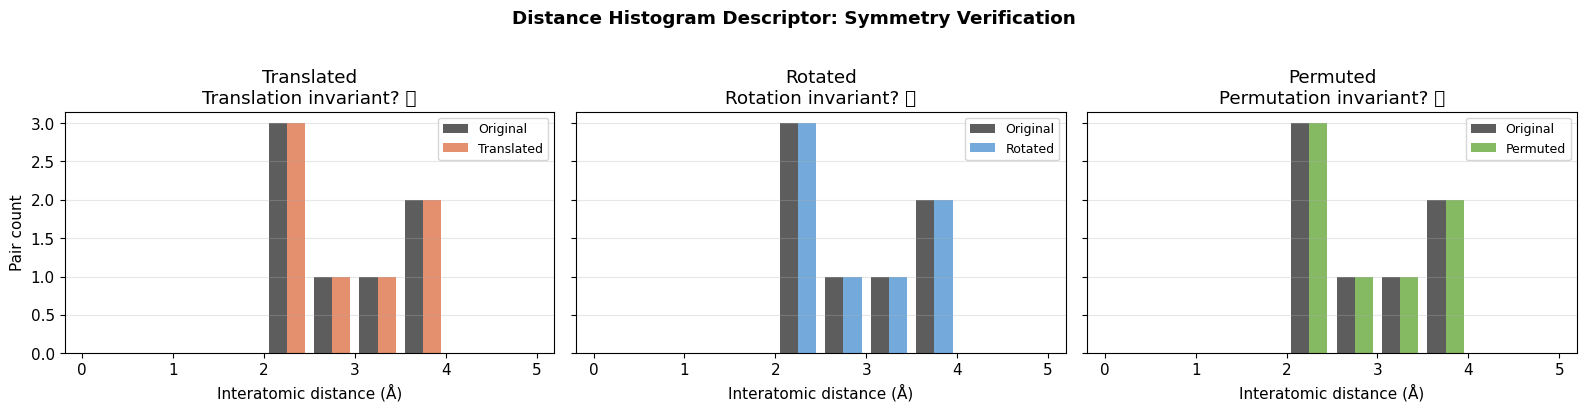

Translation invariant?   True
Rotation invariant?      True
Permutation invariant?   True


In [3]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────

def simple_descriptor(positions, cutoff=5.0, nbins=10):
    """Distance histogram descriptor — counts pairs in each distance bin."""
    N = len(positions)
    distances = []
    for i in range(N):
        for j in range(i+1, N):
            r = np.linalg.norm(positions[i] - positions[j])
            if r < cutoff:
                distances.append(r)
    hist, bin_edges = np.histogram(distances, bins=nbins, range=(0, cutoff))
    return hist.astype(float), bin_edges

def rotation_matrix(axis, angle):
    """Rodrigues' rotation formula — rotate by 'angle' around 'axis'."""
    axis = axis / np.linalg.norm(axis)
    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])
    return np.eye(3) + np.sin(angle)*K + (1-np.cos(angle))*K@K

# ── Test with a 5-atom random cluster ────────────────────────────────────────
pos = np.random.randn(5, 3) * 2
d_orig,  edges = simple_descriptor(pos)
d_trans, _     = simple_descriptor(pos + np.array([10, 20, 30]))   # translated
R = rotation_matrix(np.array([1,1,1]), np.pi/3)
d_rot,   _     = simple_descriptor(pos @ R.T)                       # rotated
d_perm,  _     = simple_descriptor(pos[[1,0,2,3,4]])                # permuted

bin_centers = 0.5*(edges[:-1] + edges[1:])

# ── Visualise ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for ax, d_mod, label, color, check in zip(
    axes,
    [d_trans, d_rot, d_perm],
    ['Translated', 'Rotated', 'Permuted'],
    ['#E07B54', '#5B9BD5', '#70AD47'],
    ['Translation invariant?', 'Rotation invariant?', 'Permutation invariant?']
):
    width = bin_centers[1] - bin_centers[0]
    ax.bar(bin_centers - width*0.2, d_orig,  width*0.4, label='Original', color='#404040', alpha=0.85)
    ax.bar(bin_centers + width*0.2, d_mod,   width*0.4, label=label, color=color, alpha=0.85)
    ax.set_xlabel('Interatomic distance (Å)')
    ax.set_title(f'{label}\n{check} {"✅" if np.allclose(d_orig, d_mod) else "❌"}')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

axes[0].set_ylabel('Pair count')
plt.suptitle('Distance Histogram Descriptor: Symmetry Verification', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('Translation invariant?  ', np.allclose(d_orig, d_trans))
print('Rotation invariant?     ', np.allclose(d_orig, d_rot))
print('Permutation invariant?  ', np.allclose(d_orig, d_perm))

### Step 1.2 — Experiment: What does the cutoff do?

The `cutoff` parameter defines the maximum distance we consider. Atoms further apart than this are ignored (they are not in each other's local environment).

**Your task:** Change `cutoff_distance` and `num_bins` and observe how the histogram changes. Then answer the reflection.

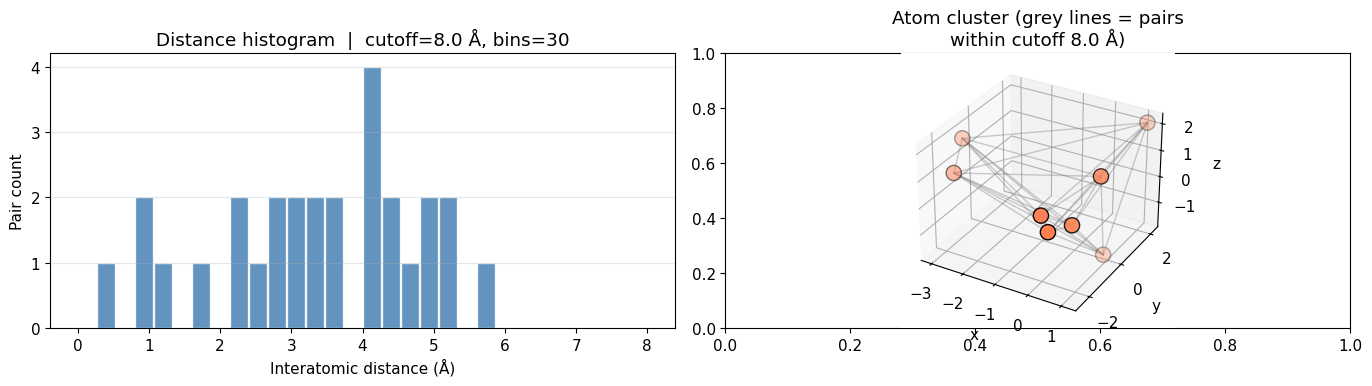

Total possible pairs: 28
Pairs within cutoff:  28  (100%)
Descriptor dimension: 30


In [11]:
# ── EXPERIMENT CELL ──────────────────────────────────────────────────────────
# 👉 CHANGE THESE:
cutoff_distance = 8.0   # <-- try: 2.0, 3.0, 5.0, 8.0  (Å)
num_bins        = 30    # <-- try: 5, 10, 20, 50

# ── (do not change below) ────────────────────────────────────────────────────
pos = np.random.randn(8, 3) * 2
d, edges = simple_descriptor(pos, cutoff=cutoff_distance, nbins=num_bins)
bin_centers = 0.5*(edges[:-1] + edges[1:])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: the histogram
axes[0].bar(bin_centers, d, width=bin_centers[1]-bin_centers[0]-0.02,
            color='steelblue', alpha=0.85, edgecolor='white')
axes[0].set_xlabel('Interatomic distance (Å)')
axes[0].set_ylabel('Pair count')
axes[0].set_title(f'Distance histogram  |  cutoff={cutoff_distance} Å, bins={num_bins}')
axes[0].grid(axis='y', alpha=0.3)

# Right: 3D scatter of the cluster
ax3d = fig.add_subplot(1,2,2, projection='3d')
ax3d.scatter(*pos.T, s=120, c='coral', edgecolors='black', zorder=5)
for i in range(len(pos)):
    for j in range(i+1, len(pos)):
        r = np.linalg.norm(pos[i]-pos[j])
        if r < cutoff_distance:
            ax3d.plot(*zip(pos[i], pos[j]), 'gray', alpha=0.4, linewidth=1)
ax3d.set_title(f'Atom cluster (grey lines = pairs\nwithin cutoff {cutoff_distance} Å)')
ax3d.set_xlabel('x'); ax3d.set_ylabel('y'); ax3d.set_zlabel('z')

plt.tight_layout()
plt.show()

total_pairs = int(len(pos)*(len(pos)-1)/2)
counted = int(d.sum())
print(f'Total possible pairs: {total_pairs}')
print(f'Pairs within cutoff:  {counted}  ({100*counted/total_pairs:.0f}%)')
print(f'Descriptor dimension: {len(d)}')

**Reflection 1.2**  — Answer in the cell below:
- What happens to the descriptor when you increase the cutoff? Is more information always better?
- If `num_bins` is too small (e.g., 5), what physical detail is lost? What if it is too large (e.g., 50)?

As we increase the cutoff, the Pairs within cutoff increases, it can depend on the model if more information is better, but typically as long as the information isn't garbage it is useful

If we make the number of bins too small we lose the shape of the distribution as everything gets bundled together, but as we increase the number of bins we may also lose the shape of the distribution as all data is more spread our and is more granular leaving gaps or spaces between groups

---
# Part 2: Invariance vs. Equivariance — Energy and Forces

## The key distinction


**Invariant** (scalars): $Q(\mathbf{R}\mathbf{r}) = Q(\mathbf{r})$
- Energy, distances, angles

**Equivariant** (vectors): $\mathbf{Q}(\mathbf{R}\mathbf{r}) = \mathbf{R}\mathbf{Q}(\mathbf{r})$
- Forces, dipoles

##  Key Question: Can Invariant MLIPs Predict Equivariant Forces?

**YES!** Through the chain rule:

$$\mathbf{F}_i = -\frac{\partial E}{\partial \mathbf{r}_i} = -\frac{\partial E}{\partial \mathbf{D}} \cdot \frac{\partial \mathbf{D}}{\partial \mathbf{r}_i}$$

Even though $E$ and $\mathbf{D}$ are invariant, the derivative $\frac{\partial \mathbf{D}}{\partial \mathbf{r}_i}$ encodes directional information!

**Mathematical proof:**
$$\mathbf{F}_i(\mathbf{R}\mathbf{r}) = -\frac{\partial E(\mathbf{D}(\mathbf{R}\mathbf{r}))}{\partial(\mathbf{R}\mathbf{r}_i)} = \mathbf{R}\mathbf{F}_i(\mathbf{r})$$


### Step 2.1 — Run the demo: energy invariance and force equivariance

In [ ]:
def lj_energy(pos, eps=1.0, sig=1.0):
    """Lennard-Jones energy (invariant)."""
    # YOUR CODE HERE
    raise NotImplementedError()

def lj_forces(pos, eps=1.0, sig=1.0):
    """Numerical forces via finite differences."""
    # YOUR CODE HERE
    raise NotImplementedError()

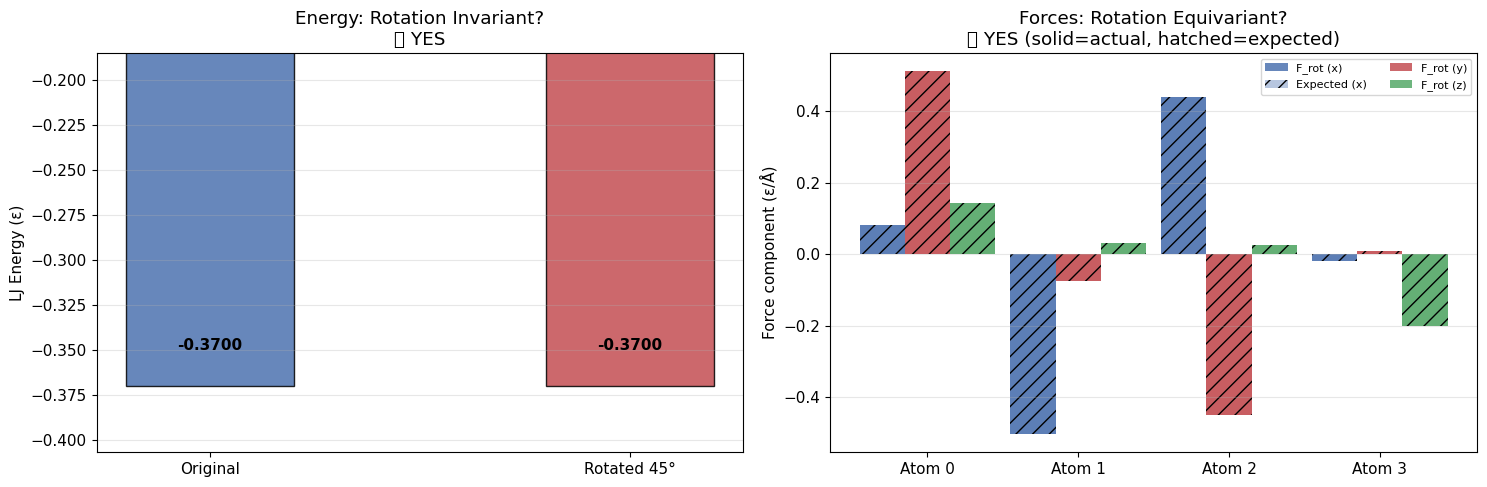

Energy invariant:    True
Forces equivariant:  True


In [12]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────

def lj_energy(pos, eps=1.0, sig=1.0):
    """Lennard-Jones potential energy (rotation-invariant by construction)."""
    E = 0.0
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            r = np.linalg.norm(pos[i]-pos[j])
            if r > 1e-9:
                E += 4*eps*((sig/r)**12 - (sig/r)**6)
    return E

def lj_forces(pos, eps=1.0, sig=1.0, h=1e-6):
    """Forces via central finite differences: F = -dE/dr."""
    F = np.zeros_like(pos)
    for i in range(len(pos)):
        for d in range(3):
            pos_p, pos_m = pos.copy(), pos.copy()
            pos_p[i,d] += h;  pos_m[i,d] -= h
            F[i,d] = -(lj_energy(pos_p,eps,sig) - lj_energy(pos_m,eps,sig)) / (2*h)
    return F

# ── Test setup ────────────────────────────────────────────────────────────────
pos = np.array([[0,0,0],[2,0,0],[1,1.5,0],[0.5,0,2]], dtype=float)
R   = rotation_matrix(np.array([0,0,1]), np.pi/4)   # 45° around z

E_orig = lj_energy(pos)
E_rot  = lj_energy(pos @ R.T)
F_orig = lj_forces(pos)
F_rot  = lj_forces(pos @ R.T)
F_expected = F_orig @ R.T   # equivariance means F should rotate with the system

# ── Visualise ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left panel: energy invariance
ax = axes[0]
bars = ax.bar(['Original', 'Rotated 45°'], [E_orig, E_rot],
              color=['#4C72B0','#C44E52'], alpha=0.85, edgecolor='black', width=0.4)
for bar, val in zip(bars, [E_orig, E_rot]):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02,
            f'{val:.4f}', ha='center', fontweight='bold')
ax.set_ylabel('LJ Energy (ε)')
ax.set_title(f'Energy: Rotation Invariant?\n{"✅ YES" if np.isclose(E_orig, E_rot) else "❌ NO"}')
ax.set_ylim(min(E_orig, E_rot)*1.1, max(E_orig, E_rot)*0.5)
ax.grid(axis='y', alpha=0.3)

# Right panel: force equivariance (compare rotated forces to expected)
ax = axes[1]
atom_labels = [f'Atom {i}' for i in range(len(pos))]
components = ['x', 'y', 'z']
x = np.arange(len(pos))
width = 0.3
for k, (comp, color) in enumerate(zip(components, ['#4C72B0','#C44E52','#55A868'])):
    ax.bar(x - width + k*width, F_rot[:,k],      width, alpha=0.85,
           label=f'F_rot ({comp})', color=color)
    ax.bar(x - width + k*width, F_expected[:,k], width, alpha=0.4,
           color=color, hatch='//', label=f'Expected ({comp})' if k==0 else '_')
ax.set_xticks(x); ax.set_xticklabels(atom_labels)
ax.set_ylabel('Force component (ε/Å)')
equivariant = np.allclose(F_rot, F_expected, atol=1e-4)
ax.set_title(f'Forces: Rotation Equivariant?\n{"✅ YES (solid=actual, hatched=expected)" if equivariant else "❌ NO"}')
ax.legend(fontsize=8, ncol=2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
print(f'Energy invariant:    {np.isclose(E_orig, E_rot)}')
print(f'Forces equivariant:  {np.allclose(F_rot, F_expected, atol=1e-4)}')

### Step 2.2 — Experiment: Try different rotations

The energy must be invariant under **any** rotation. Try different rotation axes and angles.

Rotation axis: [0, 0, 1]  |  Angle: 0.250π rad
Energy original: -0.370037
Energy rotated:  -0.370037
Energy invariant?   True
Forces equivariant? True


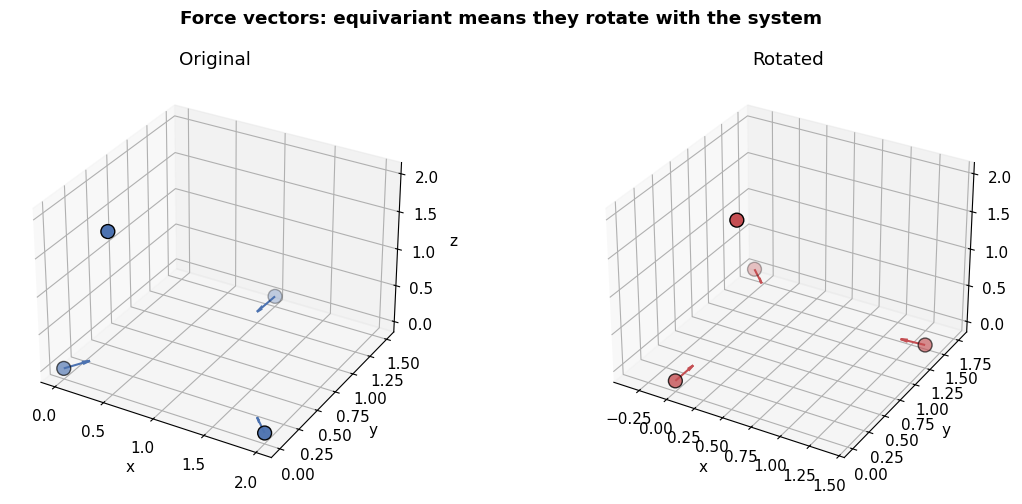

In [15]:
# ── EXPERIMENT CELL ──────────────────────────────────────────────────────────
# 👉 CHANGE THESE:
rotation_axis  = [0, 0, 1]   # <-- try: [1,0,0], [0,1,0], [0,0,1], [1,1,1]
rotation_angle = np.pi/4     # <-- try: np.pi/6, np.pi/4, np.pi/2, np.pi, 2*np.pi

# ── (do not change below) ────────────────────────────────────────────────────
pos = np.array([[0,0,0],[2,0,0],[1,1.5,0],[0.5,0,2]], dtype=float)
R = rotation_matrix(np.array(rotation_axis, dtype=float), rotation_angle)

E_orig = lj_energy(pos)
E_rot  = lj_energy(pos @ R.T)
F_orig = lj_forces(pos)
F_rot  = lj_forces(pos @ R.T)

print(f'Rotation axis: {rotation_axis}  |  Angle: {rotation_angle/np.pi:.3f}π rad')
print(f'Energy original: {E_orig:.6f}')
print(f'Energy rotated:  {E_rot:.6f}')
print(f'Energy invariant?   {np.isclose(E_orig, E_rot)}')
print(f'Forces equivariant? {np.allclose(F_rot, F_orig @ R.T, atol=1e-4)}')

# Visualise force vectors before/after
fig = plt.figure(figsize=(12, 5))
for idx, (positions, forces, title, color) in enumerate([
    (pos,        F_orig, 'Original',  '#4C72B0'),
    (pos @ R.T, F_rot,  'Rotated',   '#C44E52'),
]):
    ax = fig.add_subplot(1, 2, idx+1, projection='3d')
    ax.scatter(*positions.T, s=100, c=color, edgecolors='black', zorder=5)
    scale = 0.4
    for i in range(len(positions)):
        ax.quiver(*positions[i], *forces[i]*scale, color=color, arrow_length_ratio=0.3)
    ax.set_title(title)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.suptitle('Force vectors: equivariant means they rotate with the system', fontweight='bold')
plt.tight_layout()
plt.show()

**Reflection 2.2**  — Answer in the cell below:
- Try `rotation_angle = 2*np.pi` (a full 360° rotation). What do you expect? Does it work?
- In your own words: why does an invariant energy model automatically give equivariant forces?

*Your answer here...*

---
# Part 3: SOAP — Smooth Overlap of Atomic Positions 

## What is SOAP?

SOAP is a state-of-the-art descriptor that builds a **smooth atomic density** around each atom, then extracts rotation-invariant features from it. Instead of counting discrete pairs (like the distance histogram), it spreads each atom out as a Gaussian and analyses the resulting density field.

The key parameters are:
| Parameter | Meaning | Effect of increasing |
|---|---|---|
| `r_cut` | Cutoff radius (Å) — how far to look | More neighbours included |
| `n_max` | Number of radial basis functions | More radial detail |
| `l_max` | Maximum angular momentum | More angular/directional detail |

The descriptor dimension grows as roughly **n_max² × (l_max+1)** per species pair.



## Theory: Smooth Overlap of Atomic Positions

SOAP builds a local atomic density and then creates rotation-invariant features.

### Step 1: Gaussian Atomic Density

$$\rho_i(\mathbf{r}) = \sum_{j \neq i} \exp\left(-\frac{|\mathbf{r}-\mathbf{r}_{ij}|^2}{2\sigma^2}\right) f_c(r_{ij})$$

where $f_c(r)$ is a smooth cutoff:

$$f_c(r) = \begin{cases}
\frac{1}{2}\left[\cos\left(\frac{\pi r}{r_{cut}}\right) + 1\right] & r < r_{cut} \\
0 & r \geq r_{cut}
\end{cases}$$

### Step 2: Radial Basis Expansion

Expand in radial basis $g_n(r)$ and spherical harmonics $Y_l^m$:

$$c_{nlm} = \int Y_l^m(\hat{\mathbf{r}}) g_n(r) \rho(\mathbf{r}) d\mathbf{r}$$

### Step 3: Power Spectrum (Rotation Invariant)

The SOAP power spectrum is:

$$p_{nn'l} = \pi \sqrt{\frac{8}{2l+1}} \sum_{m=-l}^{l} c_{nlm} c^*_{n'lm}$$

**Properties:**
-  Rotation invariant (by summing over $m$)
-  Translation invariant (relative positions)
-  Permutation invariant (sum over neighbors)
-  Continuous and smooth


### Step 3.1 — Run the demo: SOAP for water and methane

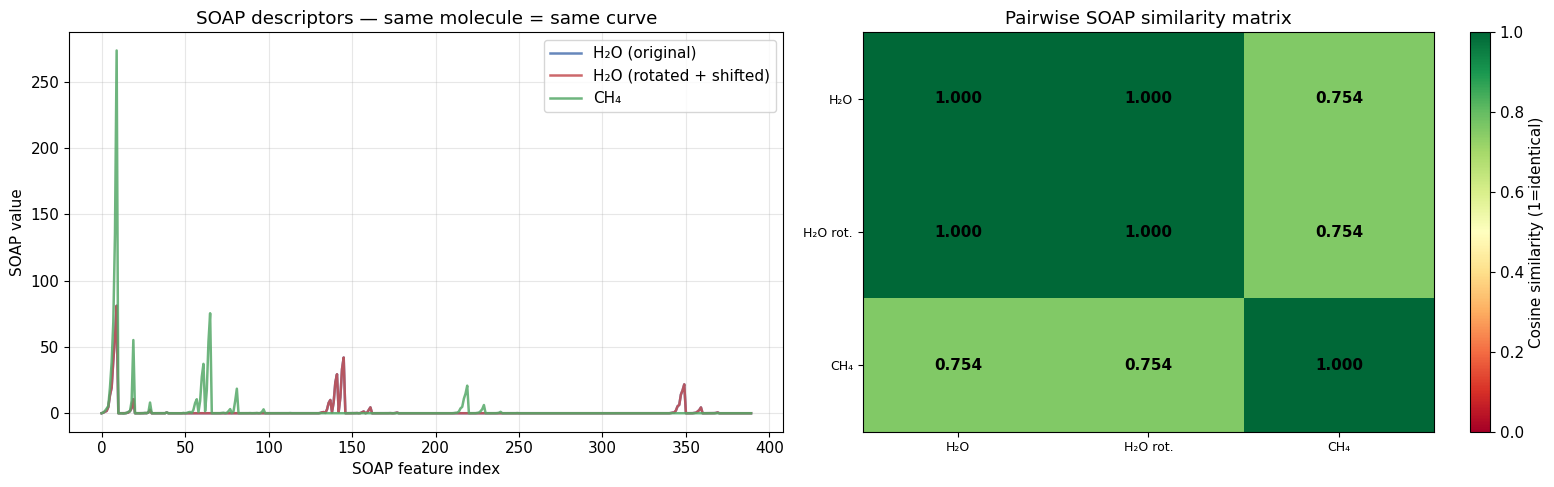

H₂O vs H₂O (rotated+translated): similarity = 1.000000  → should be ~1.0
H₂O vs CH₄:                       similarity = 0.754157  → should be << 1.0


In [16]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────

def compute_soap(structures, species, r_cut=5.0, n_max=4, l_max=4):
    """Compute averaged SOAP descriptor for a list of ASE Atoms objects."""
    soap = SOAP(species=species, r_cut=r_cut, n_max=n_max, l_max=l_max,
                periodic=False, sparse=False)
    return np.array([soap.create(s).mean(axis=0) for s in structures])

# Build three molecules
water1  = molecule('H2O')
water2  = molecule('H2O'); water2.rotate(45, 'z'); water2.translate([5,5,5])
methane = molecule('CH4')

structures = [water1, water2, methane]
names      = ['H₂O (original)', 'H₂O (rotated + shifted)', 'CH₄']
descs = compute_soap(structures, species=['H','C','O'])

# Cosine similarity
def cosine_sim(a, b):
    return np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b))

sim_water = cosine_sim(descs[0], descs[1])
sim_diff  = cosine_sim(descs[0], descs[2])

# ── Visualise ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: descriptor vectors
colors = ['#4C72B0', '#C44E52', '#55A868']
for desc, name, color in zip(descs, names, colors):
    axes[0].plot(desc, label=name, linewidth=1.8, alpha=0.85, color=color)
axes[0].set_xlabel('SOAP feature index')
axes[0].set_ylabel('SOAP value')
axes[0].set_title('SOAP descriptors — same molecule = same curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: similarity heatmap
n = len(structures)
sim_matrix = np.array([[cosine_sim(descs[i], descs[j]) for j in range(n)] for i in range(n)])
im = axes[1].imshow(sim_matrix, vmin=0, vmax=1, cmap='RdYlGn', aspect='auto')
plt.colorbar(im, ax=axes[1], label='Cosine similarity (1=identical)')
axes[1].set_xticks(range(n)); axes[1].set_xticklabels(['H₂O','H₂O rot.','CH₄'], fontsize=9)
axes[1].set_yticks(range(n)); axes[1].set_yticklabels(['H₂O','H₂O rot.','CH₄'], fontsize=9)
for i in range(n):
    for j in range(n):
        axes[1].text(j, i, f'{sim_matrix[i,j]:.3f}', ha='center', va='center',
                     fontweight='bold', fontsize=11,
                     color='white' if sim_matrix[i,j] < 0.5 else 'black')
axes[1].set_title('Pairwise SOAP similarity matrix')

plt.tight_layout()
plt.show()

print(f'H₂O vs H₂O (rotated+translated): similarity = {sim_water:.6f}  → should be ~1.0')
print(f'H₂O vs CH₄:                       similarity = {sim_diff:.6f}  → should be << 1.0')

### Step 3.2 — Experiment: How do SOAP parameters affect descriptor size and quality?

**Your task:** Change `n_max` and `l_max` and observe how the descriptor dimension changes. Also try comparing `H₂O` to `H₂S` (a similar molecule) — do they look similar in SOAP space?

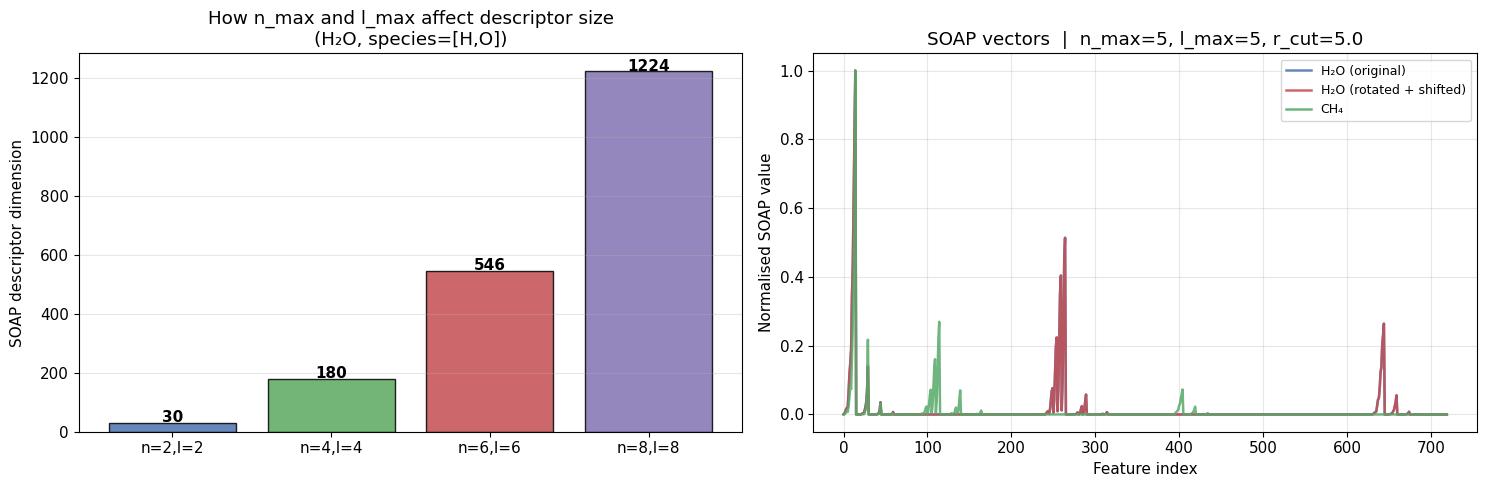

n_max=5, l_max=5, r_cut=5.0
H₂O vs H₂O rotated: 1.0000
H₂O vs CH₄:         0.7437
Descriptor dimension: 720


In [19]:
# ── EXPERIMENT CELL ──────────────────────────────────────────────────────────
# 👉 CHANGE THESE:
n_max = 5    # <-- try: 2, 4, 6, 8
l_max = 5    # <-- try: 2, 4, 6, 8
r_cut = 5.0  # <-- try: 3.0, 5.0, 8.0

# ── (do not change below) ────────────────────────────────────────────────────
params_grid = [(2,2),(4,4),(6,6),(8,8)]
sizes = []
for nm, lm in params_grid:
    soap = SOAP(species=['H','O'], r_cut=5.0, n_max=nm, l_max=lm, periodic=False, sparse=False)
    size = soap.create(water1).shape[1]
    sizes.append(size)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: dimensionality scaling
labels = [f'n={nm},l={lm}' for nm,lm in params_grid]
bar_colors = ['#4C72B0','#5BA85F','#C44E52','#8172B2']
bars = axes[0].bar(labels, sizes, color=bar_colors, alpha=0.85, edgecolor='black')
for bar, s in zip(bars, sizes):
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+2,
                 str(s), ha='center', fontweight='bold')
axes[0].set_ylabel('SOAP descriptor dimension')
axes[0].set_title('How n_max and l_max affect descriptor size\n(H₂O, species=[H,O])')
axes[0].grid(axis='y', alpha=0.3)

# Right: current parameter descriptor plots
descs_exp = compute_soap([water1, water2, methane], species=['H','C','O'],
                          r_cut=r_cut, n_max=n_max, l_max=l_max)
for desc, name, color in zip(descs_exp, names, ['#4C72B0','#C44E52','#55A868']):
    axes[1].plot(desc/max(abs(desc)), label=name, linewidth=1.8, alpha=0.85, color=color)
axes[1].set_xlabel('Feature index')
axes[1].set_ylabel('Normalised SOAP value')
axes[1].set_title(f'SOAP vectors  |  n_max={n_max}, l_max={l_max}, r_cut={r_cut}')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

sim_w  = cosine_sim(descs_exp[0], descs_exp[1])
sim_wm = cosine_sim(descs_exp[0], descs_exp[2])
print(f'n_max={n_max}, l_max={l_max}, r_cut={r_cut}')
print(f'H₂O vs H₂O rotated: {sim_w:.4f}')
print(f'H₂O vs CH₄:         {sim_wm:.4f}')
print(f'Descriptor dimension: {len(descs_exp[0])}')

**Reflection 3.2**  — Answer in the cell below:
- How does the descriptor dimension scale with `n_max` and `l_max`? (Look at the bar chart — is it linear? quadratic?)
- The similarity of H₂O (original) vs H₂O (rotated) should always be ~1.0. Why? What would it mean if it wasn't?
- Is there a trade-off between descriptor size and accuracy? When might you prefer smaller descriptors?

It scales quadratically / in a parabola

If it wasn't then it would mean that our model is not rotationally invariant

There is a tradoff, since expand the number of SOAP descriptors quadratically it weill eventually become infeasible to use the model, so a smaller model will be more efficient

### Step 3.3 — Explore: Structure fingerprinting with SOAP

SOAP descriptors can be used to measure **chemical similarity** between structures. Run the demo below to see how a series of molecules compare.

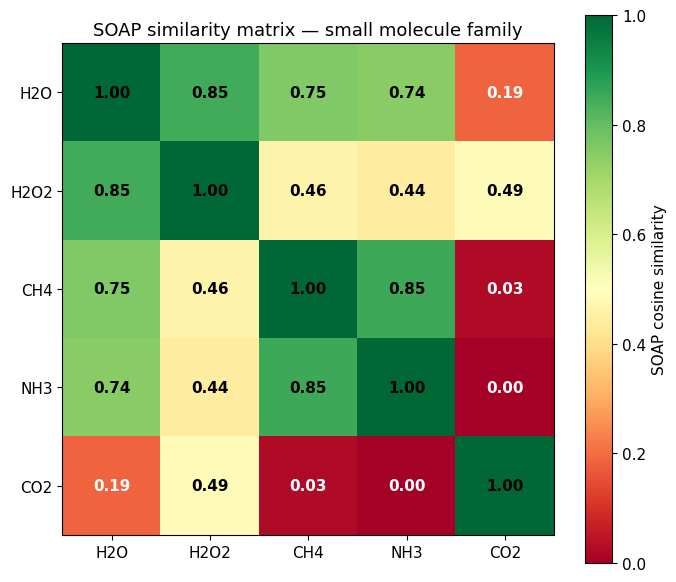

Diagonal is always 1.0 (each molecule is identical to itself)

Most similar pairs (excluding self):
  H2O    ↔ H2O2  : 0.846
  H2O    ↔ CH4   : 0.754
  H2O    ↔ NH3   : 0.743
  H2O2   ↔ CH4   : 0.461
  H2O2   ↔ NH3   : 0.442
  H2O2   ↔ CO2   : 0.488
  CH4    ↔ NH3   : 0.852


In [18]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────
# Compare a family of small molecules
mol_names = ['H2O', 'H2O2', 'CH4', 'NH3', 'CO2']
mols = [molecule(n) for n in mol_names]
descs_all = compute_soap(mols, species=['H','C','N','O'], r_cut=5.0, n_max=4, l_max=4)

n = len(mols)
sim_mat = np.array([[cosine_sim(descs_all[i], descs_all[j]) for j in range(n)] for i in range(n)])

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(sim_mat, vmin=0, vmax=1, cmap='RdYlGn')
plt.colorbar(im, ax=ax, label='SOAP cosine similarity')
ax.set_xticks(range(n)); ax.set_xticklabels(mol_names, fontsize=11)
ax.set_yticks(range(n)); ax.set_yticklabels(mol_names, fontsize=11)
for i in range(n):
    for j in range(n):
        ax.text(j, i, f'{sim_mat[i,j]:.2f}', ha='center', va='center',
                fontweight='bold', fontsize=11,
                color='white' if sim_mat[i,j] < 0.4 else 'black')
ax.set_title('SOAP similarity matrix — small molecule family', fontsize=13)
plt.tight_layout()
plt.show()

print('Diagonal is always 1.0 (each molecule is identical to itself)')
print('\nMost similar pairs (excluding self):')
for i in range(n):
    for j in range(i+1, n):
        if sim_mat[i,j] > 0.4:
            print(f'  {mol_names[i]:6s} ↔ {mol_names[j]:6s}: {sim_mat[i,j]:.3f}')

**Reflection 3.3**  — Answer in the cell below:
- Which pair of molecules is most similar according to SOAP? Does this make chemical sense?
- CO₂ and CH₄ are both carbon-containing molecules but have very different SOAP similarities to H₂O. Why?

It says that H2O and H2O2 and CH4 and NH3 are the most similar pairs

This is liekly because the Oxygens which are more electronegative behave much differently to the 4 hydrogens which aren't electronegative

---
# Part 4: ACE — Atomic Cluster Expansion 

## What is ACE?

ACE provides a **mathematically complete** basis for describing atomic environments. Unlike SOAP (which is an approximation), ACE can in principle represent **any** smooth potential energy surface exactly, given enough terms.

The building blocks are:
- **Radial basis functions** $R_n(r)$: describe how properties depend on distance
- **Spherical harmonics** $Y_l^m(\theta, \phi)$: describe angular (directional) patterns

The ACE basis vector for a central atom is built by summing these over all neighbours, then forming rotation-invariant combinations.



### The ACE Framework

Total energy as sum of body-order terms:

$$E = \sum_i E^{(1)}_i + \sum_i E^{(2)}_i + \sum_i E^{(3)}_i + ...$$

where:
- $E^{(1)}$: One-body (atomic energy)
- $E^{(2)}$: Two-body (pair interactions)
- $E^{(3)}$: Three-body (angular terms)
- $E^{(4)}$ and higher: Many-body correlations

### Mathematical Formulation

Each body-order contribution uses:

$$E^{(\nu)}_i = \sum_{\mathbf{n}} c_{\mathbf{n}} B_{\mathbf{n}}^{(\nu)}(\rho_i)$$

where $B_{\mathbf{n}}$ are **basis functions** and $c_{\mathbf{n}}$ are **learnable coefficients**.

The atomic density $\rho_i$ is expanded as:

$$\rho_i = \sum_{j \neq i} A_i(\mathbf{r}_{ij})$$

$$A_i(\mathbf{r}) = R_n(r) Y_l^m(\hat{\mathbf{r}}) Z_z$$

where:
- $R_n(r)$: Radial basis (e.g., orthogonal polynomials)
- $Y_l^m$: Spherical harmonics
- $Z_z$: Chemical species

### Body-Order Terms

**2-body:**
$$B^{(2)}_{n_1 l_1 m_1, n_2 l_2 m_2} = \sum_{jj'} A_{n_1 l_1 m_1}(\mathbf{r}_{ij}) A_{n_2 l_2 m_2}(\mathbf{r}_{ij'})$$

**3-body** (includes correlations):
$$B^{(3)}_{n_1 l_1 m_1, n_2 l_2 m_2, n_3 l_3 m_3} = \sum_{jj'j''} A_{n_1}(\mathbf{r}_{ij}) A_{n_2}(\mathbf{r}_{ij'}) A_{n_3}(\mathbf{r}_{ij''})$$

coupled through Clebsch-Gordan coefficients to ensure rotation invariance.

### Key Properties:

 **Completeness**: Can represent any smooth function with enough terms  
 **Systematic**: Clear hierarchy by body-order  
 **Efficient**: Recursive computation scheme  
 **All symmetries**: Translation, rotation, permutation invariant  

### Comparison with Other Descriptors:

| Descriptor | Completeness | Body-Order | Computational Cost |
|------------|--------------|------------|-------------------|
| SNAP | Approximate | Up to 4-body | Medium |
| SOAP | Approximate | Density overlap | Medium |
| ACE | **Complete** | **Arbitrary** | Higher (but optimized) |


### Step 4.1 — Run the demo: ACE components for different structures

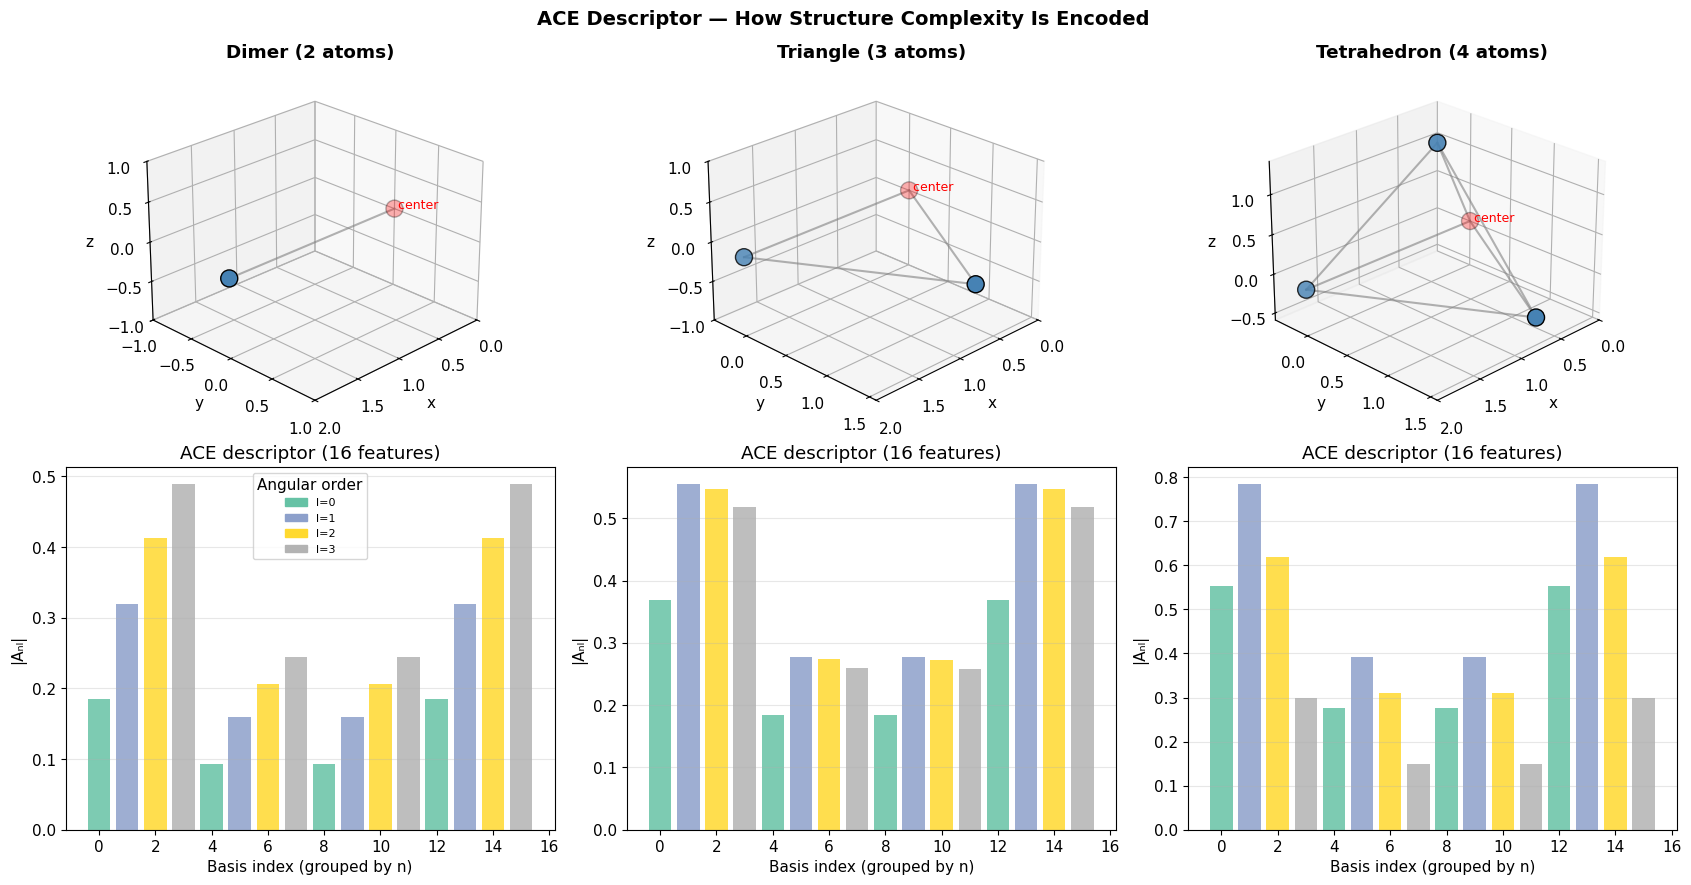

In [20]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.special import sph_harm_y


# ─────────────────────────────────────────────────────────────
# Smooth cosine cutoff
# ─────────────────────────────────────────────────────────────
def cutoff_fn(r, r_cut):
    if r <= 0 or r >= r_cut:
        return 0.0
    return 0.5 * (np.cos(np.pi * r / r_cut) + 1.0)


# ─────────────────────────────────────────────────────────────
# Chebyshev radial basis with cutoff
# ─────────────────────────────────────────────────────────────
def radial_basis(r, n, r_cut, r0=1.0):
    if r <= 0 or r >= r_cut:
        return 0.0

    x = 2.0 * (r - r0) / (r_cut - r0) - 1.0

    if n == 0:
        Tn = 1.0
    elif n == 1:
        Tn = x
    else:
        T0, T1 = 1.0, x
        for _ in range(2, n + 1):
            T0, T1 = T1, 2 * x * T1 - T0
        Tn = T1

    return Tn * cutoff_fn(r, r_cut)


# ─────────────────────────────────────────────────────────────
# ACE 2-body power spectrum descriptor
# ─────────────────────────────────────────────────────────────
def ace_descriptor(positions, center_idx, n_max, l_max, r_cut):

    center = positions[center_idx]
    A = np.zeros((n_max, l_max + 1, 2 * l_max + 1), dtype=np.complex128)

    for j, pos in enumerate(positions):
        if j == center_idx:
            continue

        rij = pos - center
        r = np.linalg.norm(rij)

        if not (1e-8 < r < r_cut):
            continue

        theta = np.arccos(np.clip(rij[2] / r, -1.0, 1.0))
        phi = np.arctan2(rij[1], rij[0])
        if phi < 0:
            phi += 2 * np.pi

        for n in range(n_max):
            Rn = radial_basis(r, n, r_cut)

            for l in range(l_max + 1):
                for m in range(-l, l + 1):
                    Ylm = sph_harm_y(l, m, theta, phi)
                    A[n, l, m + l_max] += Rn * Ylm

    B = []
    for n in range(n_max):
        for l in range(l_max + 1):
            m_slice = slice(l_max - l, l_max + l + 1)
            Bnl = np.sqrt(np.sum(np.abs(A[n, l, m_slice])**2))
            B.append(Bnl.real)

    return np.array(B)


# ─────────────────────────────────────────────────────────────
# Helper: Equal axis scaling for 3D plots
# ─────────────────────────────────────────────────────────────
def set_equal_axes(ax, positions):
    max_range = np.ptp(positions, axis=0).max() / 2
    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)


# ─────────────────────────────────────────────────────────────
# Demo structures
# ─────────────────────────────────────────────────────────────
structures = {
    "Dimer (2 atoms)": np.array([[0,0,0],[2,0,0]], dtype=float),
    "Triangle (3 atoms)": np.array([[0,0,0],[2,0,0],[1,1.73,0]], dtype=float),
    "Tetrahedron (4 atoms)": np.array([
        [0,0,0],
        [2,0,0],
        [1,1.73,0],
        [1,0.577,1.633]
    ], dtype=float),
}


# ─────────────────────────────────────────────────────────────
# Plot demo
# ─────────────────────────────────────────────────────────────
n_max_demo = 4
l_max_demo = 3
r_cut_demo = 5.0

fig = plt.figure(figsize=(17, 9))

for col, (name, pos) in enumerate(structures.items()):

    desc = ace_descriptor(pos, 0, n_max_demo, l_max_demo, r_cut_demo)

    # ── 3D structure (top row)
    ax3d = fig.add_subplot(2, 3, col + 1, projection='3d')

    ax3d.scatter(*pos.T,
                 s=150,
                 c=['red'] + ['steelblue']*(len(pos)-1),
                 edgecolors='black')

    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            ax3d.plot(*zip(pos[i], pos[j]), 'gray', alpha=0.6)

    # Clean center label
    cx, cy, cz = pos[0]
    ax3d.text(cx, cy, cz, " center",
              color='red', fontsize=9)

    ax3d.set_title(name, fontweight='bold')
    ax3d.set_xlabel('x')
    ax3d.set_ylabel('y')
    ax3d.set_zlabel('z')
    ax3d.view_init(elev=25, azim=45)

    set_equal_axes(ax3d, pos)


    # ── Descriptor plot (bottom row)
    ax = fig.add_subplot(2, 3, col + 4)

    l_colours = plt.cm.Set2(np.linspace(0, 1, l_max_demo + 1))

    for n in range(n_max_demo):
        for l in range(l_max_demo + 1):
            idx = n * (l_max_demo + 1) + l
            ax.bar(idx, desc[idx],
                   color=l_colours[l],
                   alpha=0.85,
                   label=f'l={l}' if n == 0 else "_")

    ax.set_xlabel("Basis index (grouped by n)")
    ax.set_ylabel("|Aₙₗ|")
    ax.set_title(f"ACE descriptor ({len(desc)} features)")
    ax.grid(axis='y', alpha=0.3)

    if col == 0:
        handles = [mpatches.Patch(color=l_colours[l], label=f'l={l}')
                   for l in range(l_max_demo + 1)]
        ax.legend(handles=handles, fontsize=8, title="Angular order")


plt.suptitle("ACE Descriptor — How Structure Complexity Is Encoded",
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Step 4.2 — Experiment: Change ACE resolution

**Your task:** Try different values of `n_max` and `l_max` for the ACE descriptor. Observe how the descriptor changes for each structure.

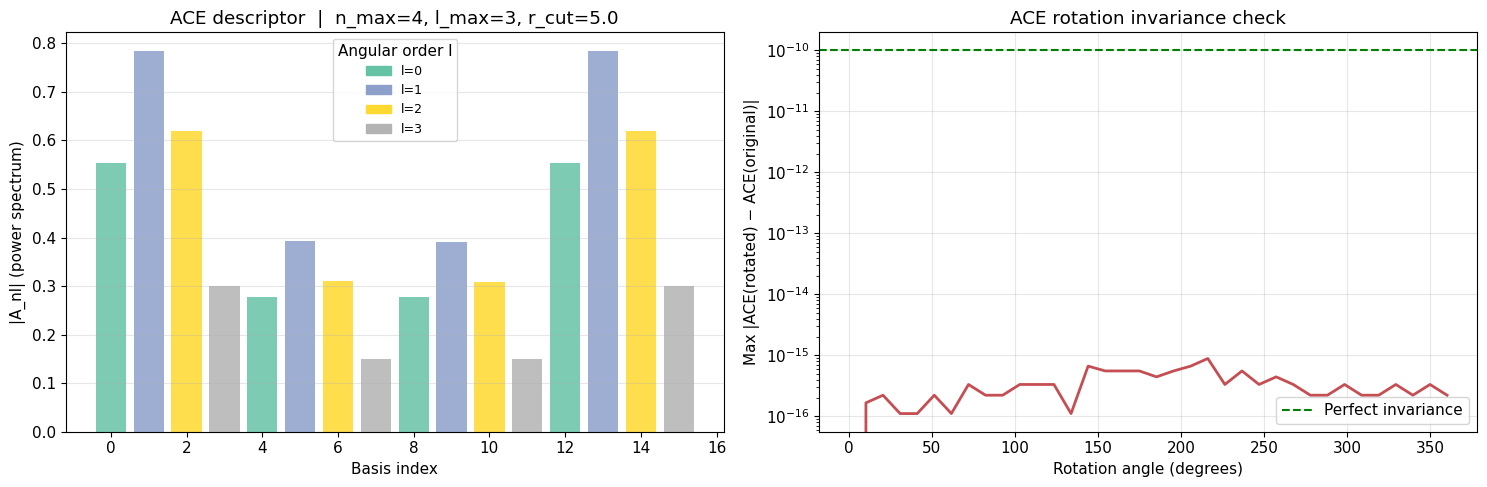

ACE descriptor dimension: 16  (= n_max × (l_max+1) = 4×4)
Max deviation under rotation: 8.88e-16  (should be ~machine precision)


In [21]:
# ── EXPERIMENT CELL ──────────────────────────────────────────────────────────
#  CHANGE THESE:
n_max_ace = 4     # <-- try: 2, 4, 6
l_max_ace = 3     # <-- try: 1, 3, 5  (higher l = more angular detail)
r_cut_ace = 5.0   # <-- try: 2.5, 5.0, 8.0

# ── (do not change below) ────────────────────────────────────────────────────
test_pos = np.array([[0,0,0],[2,0,0],[1,1.73,0],[1,0.577,1.633]], dtype=float)
desc = ace_descriptor(test_pos, 0, n_max_ace, l_max_ace, r_cut_ace)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: descriptor bar chart
l_colours = plt.cm.Set2(np.linspace(0,1,l_max_ace+1))
for n in range(n_max_ace):
    for l in range(l_max_ace+1):
        idx = n*(l_max_ace+1)+l
        axes[0].bar(idx, desc[idx], color=l_colours[l], alpha=0.85,
                    label=f'l={l}' if n==0 else '_')
handles = [mpatches.Patch(color=l_colours[l], label=f'l={l}') for l in range(l_max_ace+1)]
axes[0].legend(handles=handles, fontsize=9, title='Angular order l')
axes[0].set_xlabel('Basis index')
axes[0].set_ylabel('|A_nl| (power spectrum)')
axes[0].set_title(f'ACE descriptor  |  n_max={n_max_ace}, l_max={l_max_ace}, r_cut={r_cut_ace}')
axes[0].grid(axis='y', alpha=0.3)

# Right: check rotation invariance of ACE
angles = np.linspace(0, 2*np.pi, 36)
deviations = []
for ang in angles:
    R_test = rotation_matrix(np.array([1,1,1], dtype=float), ang)
    d_rot  = ace_descriptor(test_pos @ R_test.T, 0, n_max_ace, l_max_ace, r_cut_ace)
    deviations.append(np.max(np.abs(d_rot - desc)))

axes[1].plot(np.degrees(angles), deviations, color='#C44E52', linewidth=2)
axes[1].axhline(1e-10, color='green', linestyle='--', label='Perfect invariance')
axes[1].set_xlabel('Rotation angle (degrees)')
axes[1].set_ylabel('Max |ACE(rotated) − ACE(original)|')
axes[1].set_title('ACE rotation invariance check')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print(f'ACE descriptor dimension: {len(desc)}  (= n_max × (l_max+1) = {n_max_ace}×{l_max_ace+1})')
print(f'Max deviation under rotation: {max(deviations):.2e}  (should be ~machine precision)')

**Reflection 4.2**  — Answer in the cell below:
- The right plot shows the ACE descriptor deviation under rotations. What value do you observe, and what does this confirm?
- What is the difference between increasing `l_max` vs. increasing `n_max`? What kind of physical information does each capture?
- If `r_cut_ace` is set very small (e.g., 2.5 Å), what happens to the descriptor for the tetrahedron? Why?

*Your answer here...*

---
# Part 5: Descriptor Comparison 

Now let's put all three descriptors side by side on the same molecule and compare them.

### Step 5.1 — Run the final comparison

In [ ]:
# ── DEMO CELL (run as-is) ────────────────────────────────────────────────────
water = molecule('H2O')
pos_w = water.get_positions()

# Compute all three
d_simple, edges = simple_descriptor(pos_w, cutoff=5.0, nbins=10)
d_soap  = compute_soap([water], species=['H','O'], r_cut=5.0, n_max=4, l_max=4)[0]
d_ace   = ace_descriptor(pos_w, 0, n_max=4, l_max=3, r_cut=5.0)

# Normalise for visual comparison
def norm(v): return v / np.linalg.norm(v) if np.linalg.norm(v)>0 else v

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
specs = [
    (d_simple, f'Distance Histogram\n({len(d_simple)} features)', 'coral',    'bar'),
    (d_soap,   f'SOAP\n({len(d_soap)} features)',                 'steelblue','line'),
    (d_ace,    f'ACE (2-body)\n({len(d_ace)} features)',          'seagreen', 'bar'),
]
for ax, (d, title, color, style) in zip(axes, specs):
    dn = norm(d)
    if style == 'bar':
        ax.bar(range(len(dn)), dn, color=color, alpha=0.85, edgecolor='white')
    else:
        ax.plot(dn, color=color, linewidth=1.5, alpha=0.9)
        ax.fill_between(range(len(dn)), dn, alpha=0.2, color=color)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature index')
    ax.set_ylabel('Normalised value')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('H₂O molecule: descriptor comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print(f'\n{"Descriptor":25s} {"Features":>10s}  Rotation-invariant?')
print('-'*55)
for name, d in [('Distance Histogram', d_simple), ('SOAP', d_soap), ('ACE (2-body)', d_ace)]:
    print(f'{name:25s} {len(d):>10d}  ✅')

### Step 5.2 — Final Reflection

Answer all four questions in the cell below.

**1. Why is rotation invariance critical for atomic descriptors?**

*Your answer...*

---
**2. How can an invariant descriptor produce equivariant forces?**

*Your answer...*

---
**3. What is the main advantage of ACE over SOAP?**

*Your answer...*

---
**4. For each use case below, which descriptor (Distance Histogram / SOAP / ACE) would you choose and why?**
- (a) Quick exploratory analysis of 10 small molecules
- (b) High-accuracy MLIP for a transition metal catalyst
- (c) Comparing 10,000 crystal structures for similarity

*Your answer...*

---
## Key Takeaways

- **Symmetries are non-negotiable** — translation, rotation, and permutation invariance must be built in by design
- **Invariance ≠ equivariance** — an invariant energy model still gives correctly equivariant forces via differentiation
- **Distance Histogram**: fast, interpretable, but coarse (no angular info, discrete)
- **SOAP**: smooth, well-tested, widely used — excellent for similarity analysis
- **ACE**: mathematically complete, systematically improvable — best for high-accuracy MLIPs
- The descriptor dimension grows with resolution parameters — there is always a cost–accuracy trade-off

##  Lab Complete 

## Comparison: SOAP vs. ACE Descriptors

The following table summarizes the key technical differences between **Smooth Overlap of Atomic Positions (SOAP)** and **Atomic Cluster Expansion (ACE)**.

| Feature | SOAP | ACE |
| :--- | :--- | :--- |
| **Mathematical Basis** | Power spectrum of spherical harmonics. | Linear expansion in a symmetric polynomial basis. |
| **Body Order** | Strictly **3-body** (captures distances and angles). | **Variable/High-body** (4-body, 5-body, and beyond). |
| **Completeness** | Can be "blind" to different structures (degeneracy). | Mathematically complete; higher orders resolve all geometry. |
| **Scaling** | Scales poorly with many chemical species ($S^2$). | Scales linearly with the number of chemical species. |

---


### Mathematical Comparison: SOAP vs. ACE

Both descriptors transform the raw coordinates of a neighborhood of atoms into a fixed-length vector that is invariant to rotation, translation, and permutation.

| Step | Operation | SOAP (3-Body) | ACE (Multi-Body) |
| :--- | :--- | :--- | :--- |
| **1** | **Density Expansion** | $\rho_i(\mathbf{r}) = \sum_{nlm} c_{nlm} g_n(r) Y_{lm}(\hat{\mathbf{r}})$ | $A_{znlm} = \sum_{j} \phi_{znl}(r_j) Y_{lm}(\hat{\mathbf{r}}_j)$ |
| **2** | **Invariance Logic** | Uses the **Power Spectrum** to remove angular dependence. | Uses **Angular Coupling** (Clebsch-Gordan) to merge $N$ particles. |
| **3** | **Master Formula** | $$p_{nn'l} = \sum_{m=-l}^{l} c_{nlm}^* c_{n'lm}$$|$$B_{\nu} = \sum_{\mathbf{m}} \mathcal{C}_{\mathbf{lm}} \prod_{t=1}^{N} A_{z_t n_t l_t m_t}$$ |
| **4** | **Body Order** | **3-Body** ($2 \text{ neighbors} + 1 \text{ center}$) | **$(N+1)$-Body** (Flexible expansion) |
| **5** | **Feature Size** | Scales as $O(N_{max}^2 L_{max})$ | Scales linearly with $N$ via recursion. |
---

### Summary of the "Step 3" Math:
* **In SOAP**, the multiplication of two coefficients ($c \cdot c$) effectively measures the correlation between two neighbor atoms relative to the center, creating a **3-body** term. 
    
* **In ACE**, the product ($\prod_{t=1}^{N} A$) allows for an arbitrary number of neighbor correlations. If $N=3$, the descriptor captures **4-body** interactions (like dihedral angles), which are mathematically impossible for standard SOAP to resolve perfectly.


### Key Takeaways

1.  **Complexity & Resolution**: SOAP is limited to 3-body interactions, which means it looks at the relationship between a central atom and two neighbors. ACE can resolve 4-body (dihedral) and higher interactions, which are critical for complex chemical environments.
2.  **The "Degeneracy" Problem**: Because SOAP only sees up to 3-body terms, certain distinct atomic configurations can result in the same descriptor vector (degeneracy). ACE avoids this by being a complete basis expansion.
3.  **Computational Efficiency**: While ACE is more mathematically complex, its linear scaling with respect to chemical species makes it highly efficient for multi-component systems (e.g., high-entropy alloys).